<a href="https://colab.research.google.com/github/dorian-goueytes/L2-P-M2_motor_variability/blob/main/TD_apprentissage_par_renforcement_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-requis

## Installation et importation des bibliothèques Python

In [1]:
#!pip install ale-py
!pip install gymnasium
!pip install renderlab

import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from typing import Optional
import pickle
import matplotlib.colors as mcolors
import renderlab as rl
from matplotlib.gridspec import GridSpec

# Fonctions nécessaires au TD

In [2]:
def get_env(
    env_name: str,
    render_mode="rgb_array",
) -> gym.Env:
    env = gym.make(env_name, render_mode=render_mode)

    return env

def plot_subdivided_heatmap(data,title = 'default title'):
    #if data.shape != (16, 4):
        #raise ValueError("Input array must have shape (16,4)")

    # Reshape the data into (4, 4, 2, 2)
    if data.shape == (16, 4):
      reshaped_data = data.reshape(4, 4, 2, 2)
      # Create a new heatmap array of shape (8,8)
      heatmap_data = np.block([[reshaped_data[i, j] for j in range(4)] for i in range(4)])
      index = 8
    if data.shape == (36, 4):
      reshaped_data = data.reshape(6, 6, 2, 2)
      # Create a new heatmap array of shape (8,8)
      heatmap_data = np.block([[reshaped_data[i, j] for j in range(6)] for i in range(6)])
      index = 12



    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.get_cmap("coolwarm")
    norm = mcolors.Normalize(vmin=np.min(0), vmax=np.max(1))

    im = ax.imshow(heatmap_data, cmap=cmap, norm=norm)

    # Add labels indicating identity (Action 1, Action 2, etc.)
    action_labels = [["Left", "Down"], ["Right", "Up"]]
    for i in range(index):
        for j in range(index):
          label = action_labels[i % 2][j % 2]  # Assign Action labels based on position
          ax.text(j, i, label, ha='center', va='center', color='black', fontsize=8)

    # Add grid lines for subdivisions
    ax.set_xticks(np.arange(-0.5, index, 2), minor=True)
    ax.set_yticks(np.arange(-0.5, index, 2), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=2)
    ax.tick_params(which="minor", size=0)

    # Remove major ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

    plt.title(title)
    plt.show()
    #return fig

def argmax(a):
    # random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a), dtype=int)[a == np.max(a)])


def Qlearn(build_env, alpha=0.2, gamma=0.99,epsilon = 1, min_epsilon=0, nsteps=800000, Qmat=None, callback_freq=5000, callback=None,):

    episode_reward = 0
    mean_episodic_reward = 0
    n_episodes = 0
    step_per_episode = []
    step_count = 0
    total_reward = 0
    total_reward_acc = []
    first_reward_flag = False
    first_reward_index = 0
    spaces_s = []
    count_non_rewarded = 1
    count_rewarded = 0
    ratio = []


    #env: gym.Env = build_env()
    env = build_env
    obs, info = env.reset()
    if Qmat is None:
      Qmat = np.zeros((env.observation_space.n, env.action_space.n))
    step_check = int(nsteps/4)

    plot_steps = [1,step_check,step_check*2,step_check*3,step_check*4-1 ]
    pbar = tqdm(range(nsteps), colour="green")
    success_count = 0
    episode_count = 0

    all_cum_reward = []
    #over_reward = []
    for i in pbar:
        step_count+=1
        if np.random.rand() < epsilon:
            # Exploration: choose a random action
            action = env.action_space.sample()
        else:
            # Exploitation: choose the action with the highest Q-value
            action = argmax([Qmat[obs, i] for i in range(env.action_space.n)])

        next_obs, reward, terminated, truncated, info = env.step(action) #take an action
        episode_reward += reward
        total_reward+=reward
        total_reward_acc.append(total_reward)
        #over_reward.append(reward)

        if not terminated and not truncated:# If we haven't reached target or failed
            Q_next = max(Qmat[next_obs, action_next] for action_next in range(env.action_space.n))  # Get the maximum Q-value for the next state
            # Update Q-value using Q-learning update rule
            Qmat[obs, action] += alpha * (reward + gamma * Q_next - Qmat[obs, action])
            obs = next_obs
        else: #if we have reached the target or fell into a hole or reached the maximum amount of actions
            # Episode ends, update mean episodic reward and reset environment
            Qmat[obs, action] += alpha * (reward - Qmat[obs, action])
            n_episodes += 1
            mean_episodic_reward += (episode_reward - mean_episodic_reward) / n_episodes
            episode_count+=1
            episode_reward = 0
            step_per_episode.append(step_count)
            all_cum_reward.append((success_count/n_episodes)*100)
            step_count = 0
            if reward!=1:
              count_non_rewarded+=1
            if terminated and reward == 1:
              count_rewarded +=1
              ratio.append((count_rewarded/count_non_rewarded)*100)
              count_non_rewarded = 1
              count_rewarded = 0
              success_count+=1
              if first_reward_flag == False:
                first_reward_flag = True
                first_reward_index = i


            obs, info = env.reset()

        epsilon = max(min_epsilon, 0.999995 * epsilon)

        if i % callback_freq == 0:
            if callback is not None:
                # Execute callback function if provided
                callback(build_env, Qmat)
        pbar.set_description(f"Mean episodic reward: {mean_episodic_reward:.2f} | Epsilon: {epsilon:.2f} | Best reward: {best_reward:.2f}| Episode Count: {n_episodes}")
        if i in plot_steps:
          #spaces_s.append([Qmat, "Action space at step "+str(i)])
          plot_subdivided_heatmap(Qmat, title = "Action space at step "+str(i))

    print("Nombre d'action effectuées avant la première récompense : ", first_reward_index)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(ratio)
    if len(ratio)>10:
      ax1.plot(np.convolve(ratio, np.ones(int(len(ratio)/10))/int(len(ratio)/10), mode='valid'), color = 'k', linestyle = '--')
    ax1.set_title('% relatif essais récompensés/non récompensés')
    ax2.plot(total_reward_acc)
    ax2.set_title("Récompense totale")
    ax2.set_xlabel("Actions effectuées")
    ax2.axvline(first_reward_index, color = 'k', linestyle = '--')
    plt.show()

    #for i in spaces_s:
      #print(i)
      #plot_subdivided_heatmap(i[0], i[1])
    return Qmat, Qbest

def test(build_env, Qmat, test_steps=1000):
    global Qbest, best_reward
    #env: gym.Env = build_env()
    env = build_env
    n_episodes = 0
    tot_rewards = 0
    obs, info = env.reset()
    for _ in range(test_steps):
        # Choose the action with the highest Q-value
        action = argmax([Qmat[obs, i] for i in range(env.action_space.n)])
        next_obs, reward, terminated, truncated, info = env.step(action)
        tot_rewards += reward
        obs = next_obs
        if terminated or truncated:
            n_episodes += 1
            obs, info = env.reset()
    if best_reward < tot_rewards / n_episodes:
        # Update the best reward and Q-best if a better reward is achieved
        best_reward = tot_rewards / n_episodes
        Qbest = deepcopy(Qmat)
    return tot_rewards / n_episodes

# Partie 1 :  Comprendre le modèle d'apprentissage chez un agent virtuel


## Exercice 1 :  Exécutez les deux cellules suivantes et interprétez les résultats

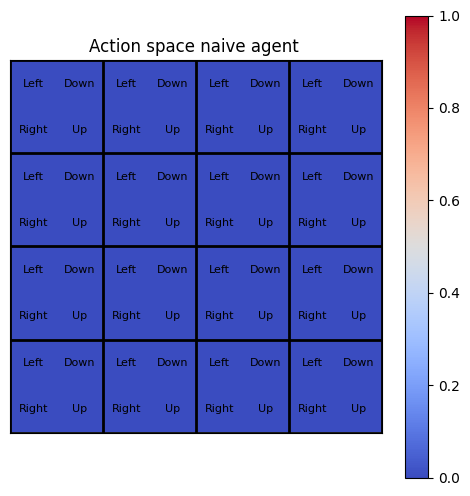

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [13]:
# @title Visualiser un agent naïf

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = np.zeros((env.observation_space.n, env.action_space.n))
plot_subdivided_heatmap(map, title = "Action space naive agent ")


for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()

Mean episodic reward: 0.00 | Epsilon: 0.40 | Best reward: 0.01| Episode Count: 0:   0%|          | 0/5000 [00:00<?, ?it/s]

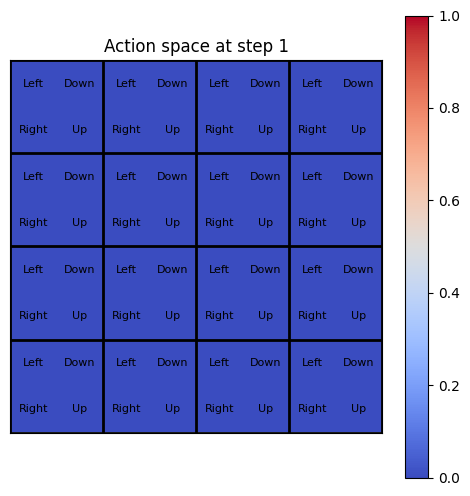

Mean episodic reward: 0.33 | Epsilon: 0.40 | Best reward: 1.00| Episode Count: 177:  24%|██▍       | 1220/5000 [00:01<00:03, 1159.71it/s]

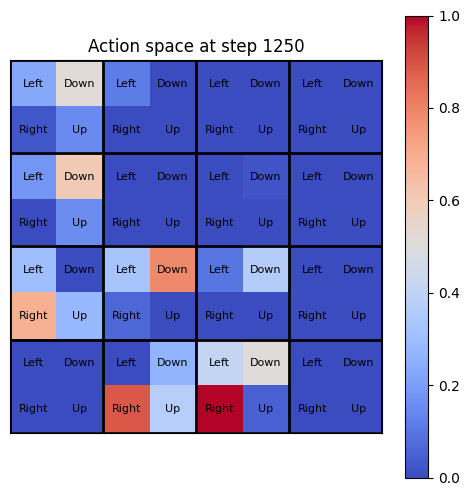

Mean episodic reward: 0.44 | Epsilon: 0.40 | Best reward: 1.00| Episode Count: 353:  50%|████▉     | 2485/5000 [00:02<00:01, 1316.05it/s]

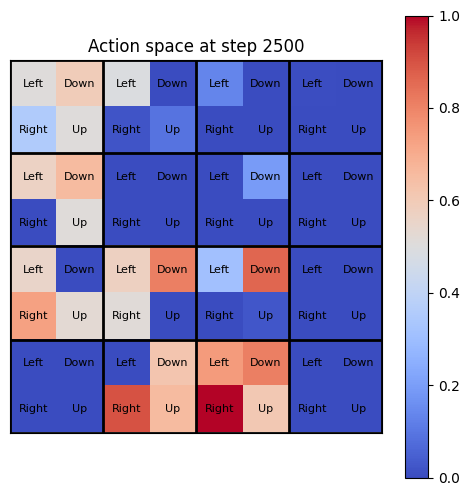

Mean episodic reward: 0.47 | Epsilon: 0.39 | Best reward: 1.00| Episode Count: 532:  73%|███████▎  | 3657/5000 [00:03<00:00, 1371.23it/s]

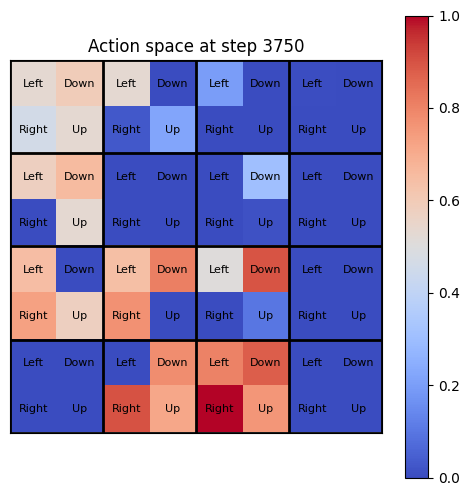

Mean episodic reward: 0.51 | Epsilon: 0.39 | Best reward: 1.00| Episode Count: 704:  99%|█████████▉| 4965/5000 [00:05<00:00, 885.72it/s]

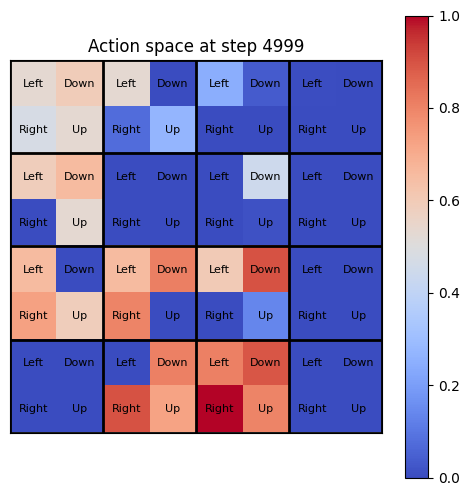

Mean episodic reward: 0.51 | Epsilon: 0.39 | Best reward: 1.00| Episode Count: 704: 100%|██████████| 5000/5000 [00:05<00:00, 907.08it/s]


Nombre d'action effectuées avant la première récompense :  207


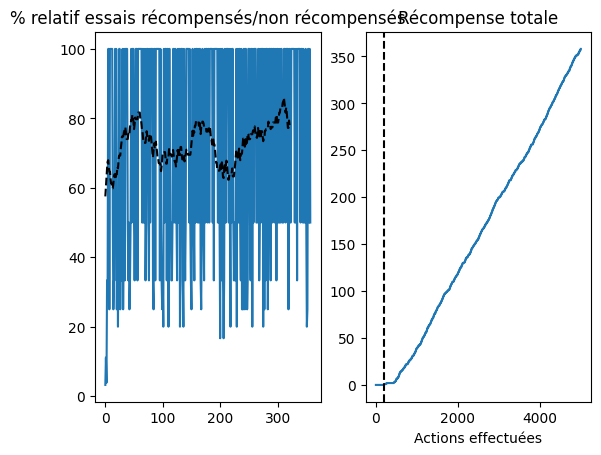

In [14]:
# @title Entrainer l'agent et comprendre les résultats
n_steps = 5000
alpha = 0.1
gamma = 0.9
epsilon = 0.4
Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [19]:
# @title Visualiser le résultat de l'entrainement
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()


Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


# Partie 2 : Comprendre les paramètres de notre agent

## Question 1 Le temps d'entrainement

En vous basant sur vos manipulations du paramètre n_steps, quel est l'effet de manipuler le temps d'entrainement sur l'apprentissage?

A quoi pourrait correspondre le temps d'entrainement dans un contexte d'apprentissage réel?

In [ ]:
# @title Effet du temps d'entrainement: Que se passe-t-il si vous réduisez progressivement le temps d'entrainement?
n_steps = 300 # @param {type:"slider", min:100, max:5000, step:100}
alpha = 0.1
gamma = 0.9
epsilon = 0.4
Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [ ]:
# @title Visualiser le résultat de l'entrainement
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()


## Question 2 :  Exploration et exploitation

En vous basant sur vos manipulations du paramètre epsilon, quel est l'effet de manipuler le ratio exploration/exploitation?

A quoi pourrait correspondre ce ratio dans un contexte d'apprentissage réel?

In [ ]:
# @title Effet du ratio exploitation/exploration: Que se passe-t-il si vous changez ce ratio?
n_steps = 5000
alpha = 0.1
gamma = 0.9
epsilon = 0.4 # @param {type:"slider", min:0, max:1, step:0.01}
Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [ ]:
# @title Visualiser le résultat de l'entrainement
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()


## Question 3 :  Exploration et exploitation

En vous basant sur vos manipulations du paramètre alpha, quel est l'effet de manipuler le taux d'apprentissage?

A quoi pourrait correspondre ce taux dans un contexte d'apprentissage réel?

In [ ]:
# @title Effet du taux d'apprentissage: Que se passe-t-il si vous changez ce taux?
n_steps = 5000
alpha = 0.1 # @param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.9
epsilon = 0.4
Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [ ]:
# @title Visualiser le résultat de l'entrainement
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()


# Partie 3 : Performance de l'agent

## Question 4 : Vous avez maintenant accès à tous les paramètres de l'agent, trouvez les paramètres qui selon vous maximisent les performances après apprentissage

In [ ]:
# @title Agent incluant tous les paramètres
n_steps = 5000 # @param {type:"slider", min:100, max:5000, step:100}
alpha = 0.1 # @param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.9
epsilon = 0.4 # @param {type:"slider", min:0, max:1, step:0.01}
Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [ ]:
# @title Visualiser le résultat de l'entrainement
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()


## Question 5 : Nous allons maintenant placer notre agent entrainé dans un environnement modifié. Quelles sont les conséquences de cette modification?


In [ ]:
# @title Performance de l'agent dans un nouvel environnement
desc=["SFFF", "FHFH", "FFFG", "HFFH"]
env = gym.make('FrozenLake-v1', desc=desc, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()

## Question 6 : Quelle solution pourrions nous proposez pour faire face aux modifications de l'environnement?

In [ ]:
# Votre réponse ici

## Question 7 : Nous allons maintenant ré-entrainer le même agent pendant un bref temps dans le nouvel environnement. Que pensez-vous de ses performances? Quelle solutions proposeriez vous pour les améliorer?

## Ré-entrainement du modèle

In [ ]:
# @Modèle complet
n_steps = 1100 # @param {type:"slider", min:100, max:5000, step:100}

Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFG", "HFFH"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest1, QFinal1 = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps,Qmat = QFinal)


In [ ]:
# @title Performance après ré-entrainement
desc=["SFFF", "FHFH", "FFFG", "HFFH"]
env = gym.make('FrozenLake-v1', desc=desc, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal1
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()

# Partie 5 : Environnement complexe

Nous allons maintenant placer notre agent dans un environnement plus complexe. En utilisant les mêmes paramètre exactement que pour le précédent agent, comparez l'apprentissage dans ce nouvel environnement.

## Question 8 :  Qu'observez-vous? Comparez avec les résultats de l'agent ayant appris dans un environnement plus simple

In [ ]:
# @title Environnement agrandi
n_steps = 5000 # @param {type:"slider", min:100, max:10000, step:100}
alpha = 0.1 # @param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.9
epsilon = 0.9 # @param {type:"slider", min:0, max:1, step:0.01}
Qbest = None
best_reward = -np.inf
desc=["SFFFFF", "FHFHFF", "HFFHFF", "HFHFFF", "HFHFHF", "FGHFHG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=False)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [ ]:
# @title Visualisation de l'agent dans un environnement agrandi
env = gym.make('FrozenLake-v1', desc=desc, map_name="4x4", is_slippery=False, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()

## Question 9 : En vous basant sur les résultats des agents évoluant dans les milieux simples et complexes, proposez une limites à la méthode d'apprentissage proposée ici

# Partie 6 :  Aléatoire dans l'environnement

In [ ]:
# @title Agent incluant tous les paramètres
n_steps = 5000 # @param {type:"slider", min:100, max:1000000, step:100}
alpha = 0.1 # @param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.9
epsilon = 0.1 # @param {type:"slider", min:0, max:1, step:0.01}
Qbest = None
best_reward = -np.inf
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
build_env = gym.make('FrozenLake-v1', desc=desc,  is_slippery=True)

Qbest, QFinal = Qlearn(build_env, alpha=alpha, epsilon = epsilon, gamma=gamma, callback=test,callback_freq = int(n_steps/5), nsteps=n_steps)

In [ ]:
# @title Visualiser le résultat de l'entrainement
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")
obs, info = env.reset()
n_episodes = 1

map = QFinal
for i in range(n_episodes):
  terminated = False
  truncated = False
  obs, info = env.reset()
  while not terminated and not truncated:
      action = argmax([map[obs, i] for i in range(env.action_space.n)])
      obs, reward, terminated, truncated, info = env.step(action)
env.play()
